In [1]:
#lib
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image 
import cv2
import sys
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [2]:
# 캐글연동
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"blingstarhamal","key":"e1d3d91691d78e6c851bff4c67c1e00e"}'}

In [3]:
ls -1ha kaggle.json

kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json
# 내가 참가한 대회 리스트 확인
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         34           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        144           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        834           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        160           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1978           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      13832           False  
house-pr

In [5]:
!kaggle datasets download -d divyansh22/dummy-astronomy-data

 59% 5.00M/8.46M [00:00<00:00, 11.8MB/s]
100% 8.46M/8.46M [00:00<00:00, 19.5MB/s]


In [6]:
!ls

dummy-astronomy-data.zip  kaggle.json  sample_data


In [7]:
!unzip dummy-astronomy-data.zip

Archive:  dummy-astronomy-data.zip
  inflating: Cutout Files/galaxy/IC3521-H01_1260_751_3.jpg  
  inflating: Cutout Files/galaxy/IC3521-H01_1300_759_3.jpg  
  inflating: Cutout Files/galaxy/IC3521-H01_1326_1169_3.jpg  
  inflating: Cutout Files/galaxy/IC3521-H01_1361_946_3.jpg  
  inflating: Cutout Files/galaxy/IC3521-H01_1399_1031_3.jpg  
  inflating: Cutout Files/galaxy/IC3521-H01_1449_1243_3.jpg  
  inflating: Cutout Files/galaxy/IC3521-H01_1536_1206_3.jpg  
  inflating: Cutout Files/galaxy/IC745_H01_1014_1208_3.jpg  
  inflating: Cutout Files/galaxy/IC745_H01_1195_791_3.jpg  
  inflating: Cutout Files/galaxy/IC745_H01_1372_890_3.jpg  
  inflating: Cutout Files/galaxy/IC745_H01_1519_1266_3.jpg  
  inflating: Cutout Files/galaxy/IC745_H01_1821_1270_3.jpg  
  inflating: Cutout Files/galaxy/IC745_H01_412_1000_3.jpg  
  inflating: Cutout Files/galaxy/IC745_H01_683_1551_3.jpg  
  inflating: Cutout Files/galaxy/IC745_H01_734_168_3.jpg  
  inflating: Cutout Files/galaxy/IC745_H01_904_1708_

In [8]:
#데이터 불러오기
data = []
labels =[]
import glob
galaxy_path = glob.glob('./Cutout Files/galaxy/*')
star_path = glob.glob('./Cutout Files/star/*')
for x in galaxy_path:
    image = cv2.imread(x,1)
    image= np.array(image)
    data.append(image)
    labels.append(0)
for x in star_path:
    image = cv2.imread(x,1)
    image= np.array(image)
    data.append(image)
    labels.append(1)   

In [9]:
data, labels= np.array(data), np.array(labels)

In [10]:
dataset= pd.DataFrame(list(zip(data, labels)), columns=['images','labels'])

In [11]:
dataset.head(5)

,images,labels
0,"[[[83, 83, 83], [115, 115, 115], [75, 75, 75],...",0
1,"[[[112, 112, 112], [61, 61, 61], [97, 97, 97],...",0
2,"[[[125, 125, 125], [74, 74, 74], [125, 125, 12...",0
3,"[[[23, 23, 23], [93, 93, 93], [77, 77, 77], [1...",0
4,"[[[86, 86, 86], [96, 96, 96], [50, 50, 50], [7...",0


In [12]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42, shuffle=True,stratify=dataset['labels'].values)

x_test, x_valid, y_test, y_valid= train_test_split(x_test, y_test, test_size=0.2,
                                                random_state=42, shuffle=True)

In [13]:
y_train, y_valid = to_categorical(y_train),  to_categorical(y_valid)

In [14]:
x_train.shape,y_train.shape

((3188, 64, 64, 3), (3188, 2))

In [15]:
x_test.shape,y_test.shape

((638, 64, 64, 3), (638,))

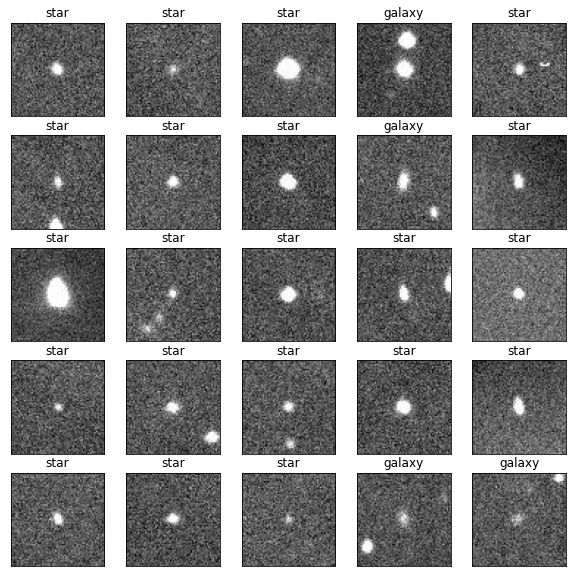

In [16]:
class_names=['star','galaxy']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    if y_test[i]==0:
        plt.title('galaxy')
    else:
        plt.title('star')
    #plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [17]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(ResNet50(include_top=True, weights=None, input_shape=(64, 64, 3), classes=2))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2)                 23591810  
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [18]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['acc'],
)

In [19]:
from tensorflow.keras import layers as tfl, optimizers
x_rescaled = tfl.Rescaling(scale=1./255)(x_train)
x_rescaled_valid=tfl.Rescaling(scale=1./255)(x_valid)

In [26]:
epochs = 50
history = model.fit(x_rescaled,y_train,validation_data=(x_rescaled_valid,y_valid),
                    epochs=epochs,
                    verbose=1,
                    batch_size=64)

Epoch 1/50
50/50 [==============================] - 5s 84ms/step - loss: 0.0678 - acc: 0.9724 - val_loss: 0.5547 - val_acc: 0.8062
Epoch 2/50
50/50 [==============================] - 3s 60ms/step - loss: 0.0097 - acc: 0.9962 - val_loss: 0.5729 - val_acc: 0.8625
Epoch 3/50
50/50 [==============================] - 3s 60ms/step - loss: 0.0018 - acc: 0.9994 - val_loss: 0.6172 - val_acc: 0.8562
Epoch 4/50
50/50 [==============================] - 3s 60ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.9023 - val_acc: 0.8125
Epoch 5/50
50/50 [==============================] - 3s 60ms/step - loss: 0.0013 - acc: 0.9997 - val_loss: 0.8847 - val_acc: 0.8625
Epoch 6/50
50/50 [==============================] - 3s 60ms/step - loss: 3.1071e-04 - acc: 1.0000 - val_loss: 1.0969 - val_acc: 0.8562
Epoch 7/50
50/50 [==============================] - 3s 60ms/step - loss: 1.9100e-04 - acc: 1.0000 - val_loss: 0.9070 - val_acc: 0.8625
Epoch 8/50
50/50 [==============================] - 3s 60ms/step - loss: 8.

In [27]:
import matplotlib.pyplot as plt

def show_graph(history_dict):
    accuracy = history_dict['acc']
    val_accuracy = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(16, 1))
    
    plt.subplot(121)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging and validation accuracy and loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy and Loss')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, -0.1))

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, 0))

    plt.show()

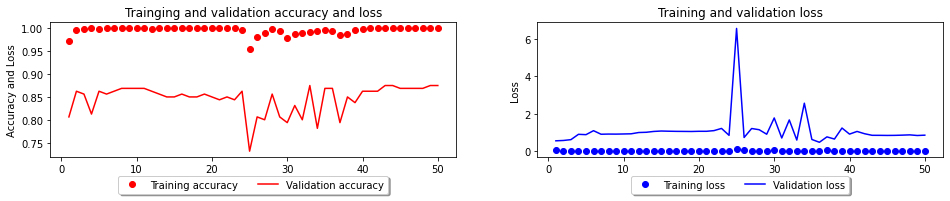

In [28]:
show_graph(history.history)


In [29]:
def smooth_curve(points, factor=.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

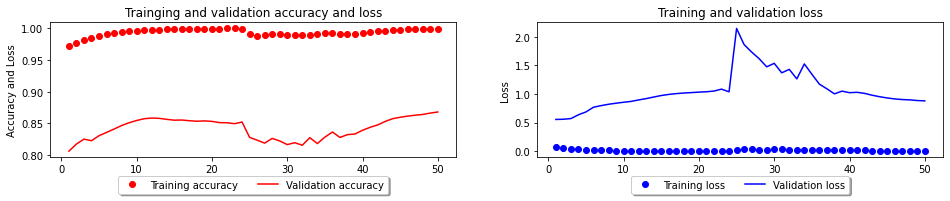

In [30]:
smooth_data = {}
for key, val in history.history.items():
    smooth_data[key] = smooth_curve(val)
show_graph(smooth_data)